``plot_trace``関数でワーニングを出さないため次のコマンド実行が必要です。

In [1]:
#!pip install --upgrade numba | tail -n 1

##  6.2 ベイズ回帰モデルによる効果検証
参照リンク　(PyMCチュートリアル)　https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#case-study-1-educational-outcomes-for-hearing-impaired-children

チュートリアルでは正則化を含んだ複雑なモデルを作っているが、簡略化して単純な線形回帰モデルを作り、各説明変数の影響度を考察する

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/notebooks/6_2_%E3%83%99%E3%82%A4%E3%82%B9%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AB%E3%82%88%E3%82%8B%E5%8A%B9%E6%9E%9C%E6%A4%9C%E8%A8%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [2]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [3]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [4]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### 6.2.1 問題設定

　本節では、Listening and Spoken Language Data Repository (LSL-DR)で提供されているデータを用いて、ベイス推論により線形回帰モデルを構築します。

　LSL-DRは難聴の子供の音声言語スキルの発達を支援する専門教育プログラムにおける国際的なデータリポジトリです。4か国の48のプログラムで、5,748人の難聴の子供の情報を収集し、彼らの音声言語の発達に影響を与える要因を調査するデータを収集しています。


　このデータセットには、以下のような項目が含まれています。

| 項目名        | 説明                                           | 項目値      |
| ------------- | ---------------------------------------------- | ----------- |
| score         | 能力テストのスコア(目的変数)                   | 0-144の整数 |
| male          | 性別                                           | 1/0         |
| siblings      | 世帯内の兄弟の数                               | 非負整数値  |
| family_inv    | 家族の関与の指標                               | 0-4の整数値 |
| non_english   | 家庭での主な言語が英語ではないか               | True/False  |
| prev_disab    | 以前の障害の存在                               | 1/0         |
| age_test      | テスト時の年齢                                 | 48-59の整数 |
| non_severe_hl | 重度の難聴ではないか                           | 1/0         |
| mother_hs     | 被験者の母親が高校卒業以上の学歴を持っているか | 1/0         |
| early_ident   | 聴覚障害が生後3か月までに特定されたか          | True/False  |
| non_white     | 非白人                                         | True/False  |


　目的変数は、学習ドメインにおいて標準化されたテストのスコア の1つを用いています(score)。

### 6.2.2 データ読み込み

In [5]:
# LSL-DR データ読み込み
df = pd.read_csv(pm.get_data('test_scores.csv'), index_col=0)

# 結果確認
display(df.head())

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.000,2.000,False,NaN,55,1.000,NaN,False,False
1,31,1,0.000,NaN,False,0.000,53,0.000,0.000,False,False
2,83,1,1.000,1.000,True,0.000,52,1.000,NaN,False,True
3,75,0,3.000,NaN,False,0.000,55,0.000,1.000,False,False
5,62,0,0.000,4.000,False,1.000,50,0.000,NaN,False,False


### 6.2.3 データ確認

#### 目的変数scoreの分布

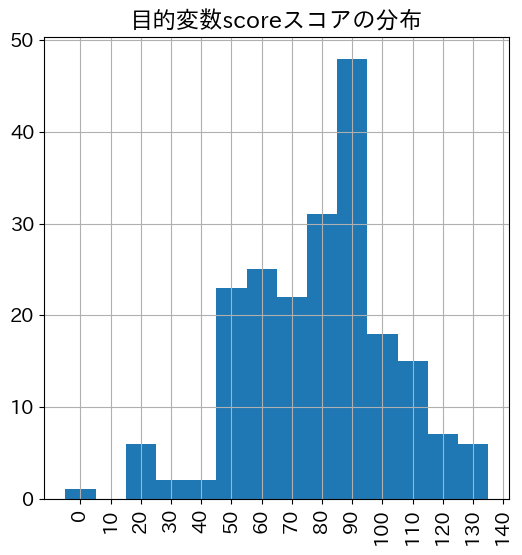

In [6]:
bins = np.arange(0, 150, 10)
fig, ax = plt.subplots()
df['score'].hist(bins=bins, align='left')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('目的変数scoreスコアの分布')
plt.xticks(bins);

#### 統計情報の確認

In [7]:
df.describe()

,score,male,siblings,family_inv,prev_disab,age_test,non_severe_hl,mother_hs
count,207.000,207.000,207.000,174.000,189.000,207.000,207.000,134.000
mean,84.193,0.512,1.126,0.977,0.238,53.546,0.415,0.701
std,24.886,0.501,0.867,1.003,0.427,3.632,0.494,0.459
min,0.000,0.000,0.000,0.000,0.000,48.000,0.000,0.000
25%,68.000,0.000,1.000,0.000,0.000,50.000,0.000,0.000
50%,87.000,1.000,1.000,1.000,0.000,54.000,0.000,1.000
75%,98.000,1.000,2.000,2.000,0.000,57.000,1.000,1.000
max,144.000,1.000,3.000,4.000,1.000,59.000,1.000,1.000


#### データ件数と欠損値の確認

In [8]:
# データ件数の確認
print(f'データ件数 {len(df)}\n')

# 欠損値値の確認
print(df.isnull().sum())

データ件数 207

score             0
male              0
siblings          0
family_inv       33
non_english       0
prev_disab       18
age_test          0
non_severe_hl     0
mother_hs        73
early_ident       0
non_white         0
dtype: int64


### 6.2.4 データ加工

#### 欠損値除去

In [9]:
# 欠損値除去
df1 = df.dropna().astype(float)

# データ件数の確認
print(f'データ件数 {len(df1)}')

データ件数 101


#### 目的変数yと説明変数Xに分離

In [10]:
y = df1.pop("score")
X = df1.copy()

# Xの結果確認
display(X.head())

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,0.000,2.000,3.000,1.000,1.000,50.000,1.000,1.000,0.000,1.000
12,1.000,1.000,0.000,0.000,0.000,48.000,1.000,1.000,1.000,0.000
14,0.000,2.000,0.000,0.000,0.000,58.000,1.000,1.000,1.000,1.000
19,1.000,0.000,2.000,0.000,0.000,50.000,1.000,1.000,0.000,1.000
21,1.000,1.000,2.000,0.000,1.000,58.000,0.000,0.000,1.000,1.000


#### Xの正規化

In [11]:
X -= X.mean()
X /= X.std()

# 結果確認
display(X.head())

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,-1.005,1.078,2.228,2.480,1.782,-0.978,1.179,0.616,-0.773,1.133
12,0.985,-0.080,-0.912,-0.399,-0.556,-1.562,1.179,0.616,1.281,-0.874
14,-1.005,1.078,-0.912,-0.399,-0.556,1.360,1.179,0.616,1.281,1.133
19,0.985,-1.239,1.181,-0.399,-0.556,-0.978,1.179,0.616,-0.773,1.133
21,0.985,-0.080,1.181,-0.399,1.782,1.360,-0.840,-1.607,1.281,1.133


#### ベイズモデル構築に必要な変数定義

In [12]:
# データ件数とデータ項目数の設定
N, D = X.shape

# 項目名一覧をcolumnsに設定する
columns = X.columns.values

# 結果確認
print(f'N: {N} (データ件数)\n')
print(f'D: {D} (説明変数項目数)\n')
print(f'項目名一覧: {columns}')

N: 101 (データ件数)

D: 10 (説明変数項目数)

項目名一覧: ['male' 'siblings' 'family_inv' 'non_english' 'prev_disab' 'age_test'
 'non_severe_hl' 'mother_hs' 'early_ident' 'non_white']


### 6.2.5 確率モデル定義

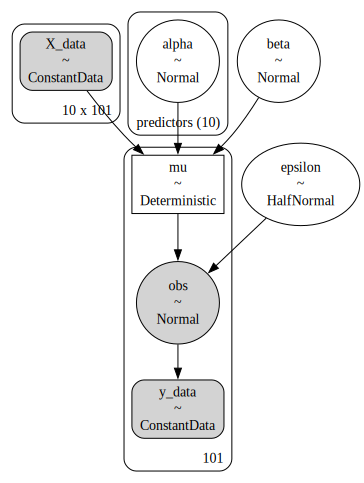

In [13]:
# 説明変数リストをpredictorsとして定義
model1 = pm.Model(coords={'predictors': columns})

with model1:
    # Xは従来のベクトルが行列になる。転置していることに注意
    X_data = pm.ConstantData('X_data', X.T)

    # yが回帰モデルの目的変数
    y_data = pm.ConstantData('y_data', y)

    # 単回帰のときスカラーだったalphaは重回帰でベクトルになる
    # 要素数はpredictorsにより間接的に指定できる(上でcoordsパラメータを指定した効果)
    alpha = pm.Normal('alpha', mu=0.0, sigma=10.0, dims='predictors')

    # betaとepsilonは単回帰の時と同じ(パラメータ値の選定理由は本文で説明)
    beta = pm.Normal('beta', mu=100.0, sigma=25.0)
    epsilon = pm.HalfNormal('epsilon', sigma=25.0)

    # muの計算では、単回帰のときのかけ算が内積に変わっている
    mu = pm.Deterministic('mu', alpha @ X_data + beta)

    # 正規分布の定義は5.2節の単回帰と同じ
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model1)
display(g)

### 6.2.6 サンプリングと結果分析

#### サンプリングとplot_trace関数による」結果分析

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


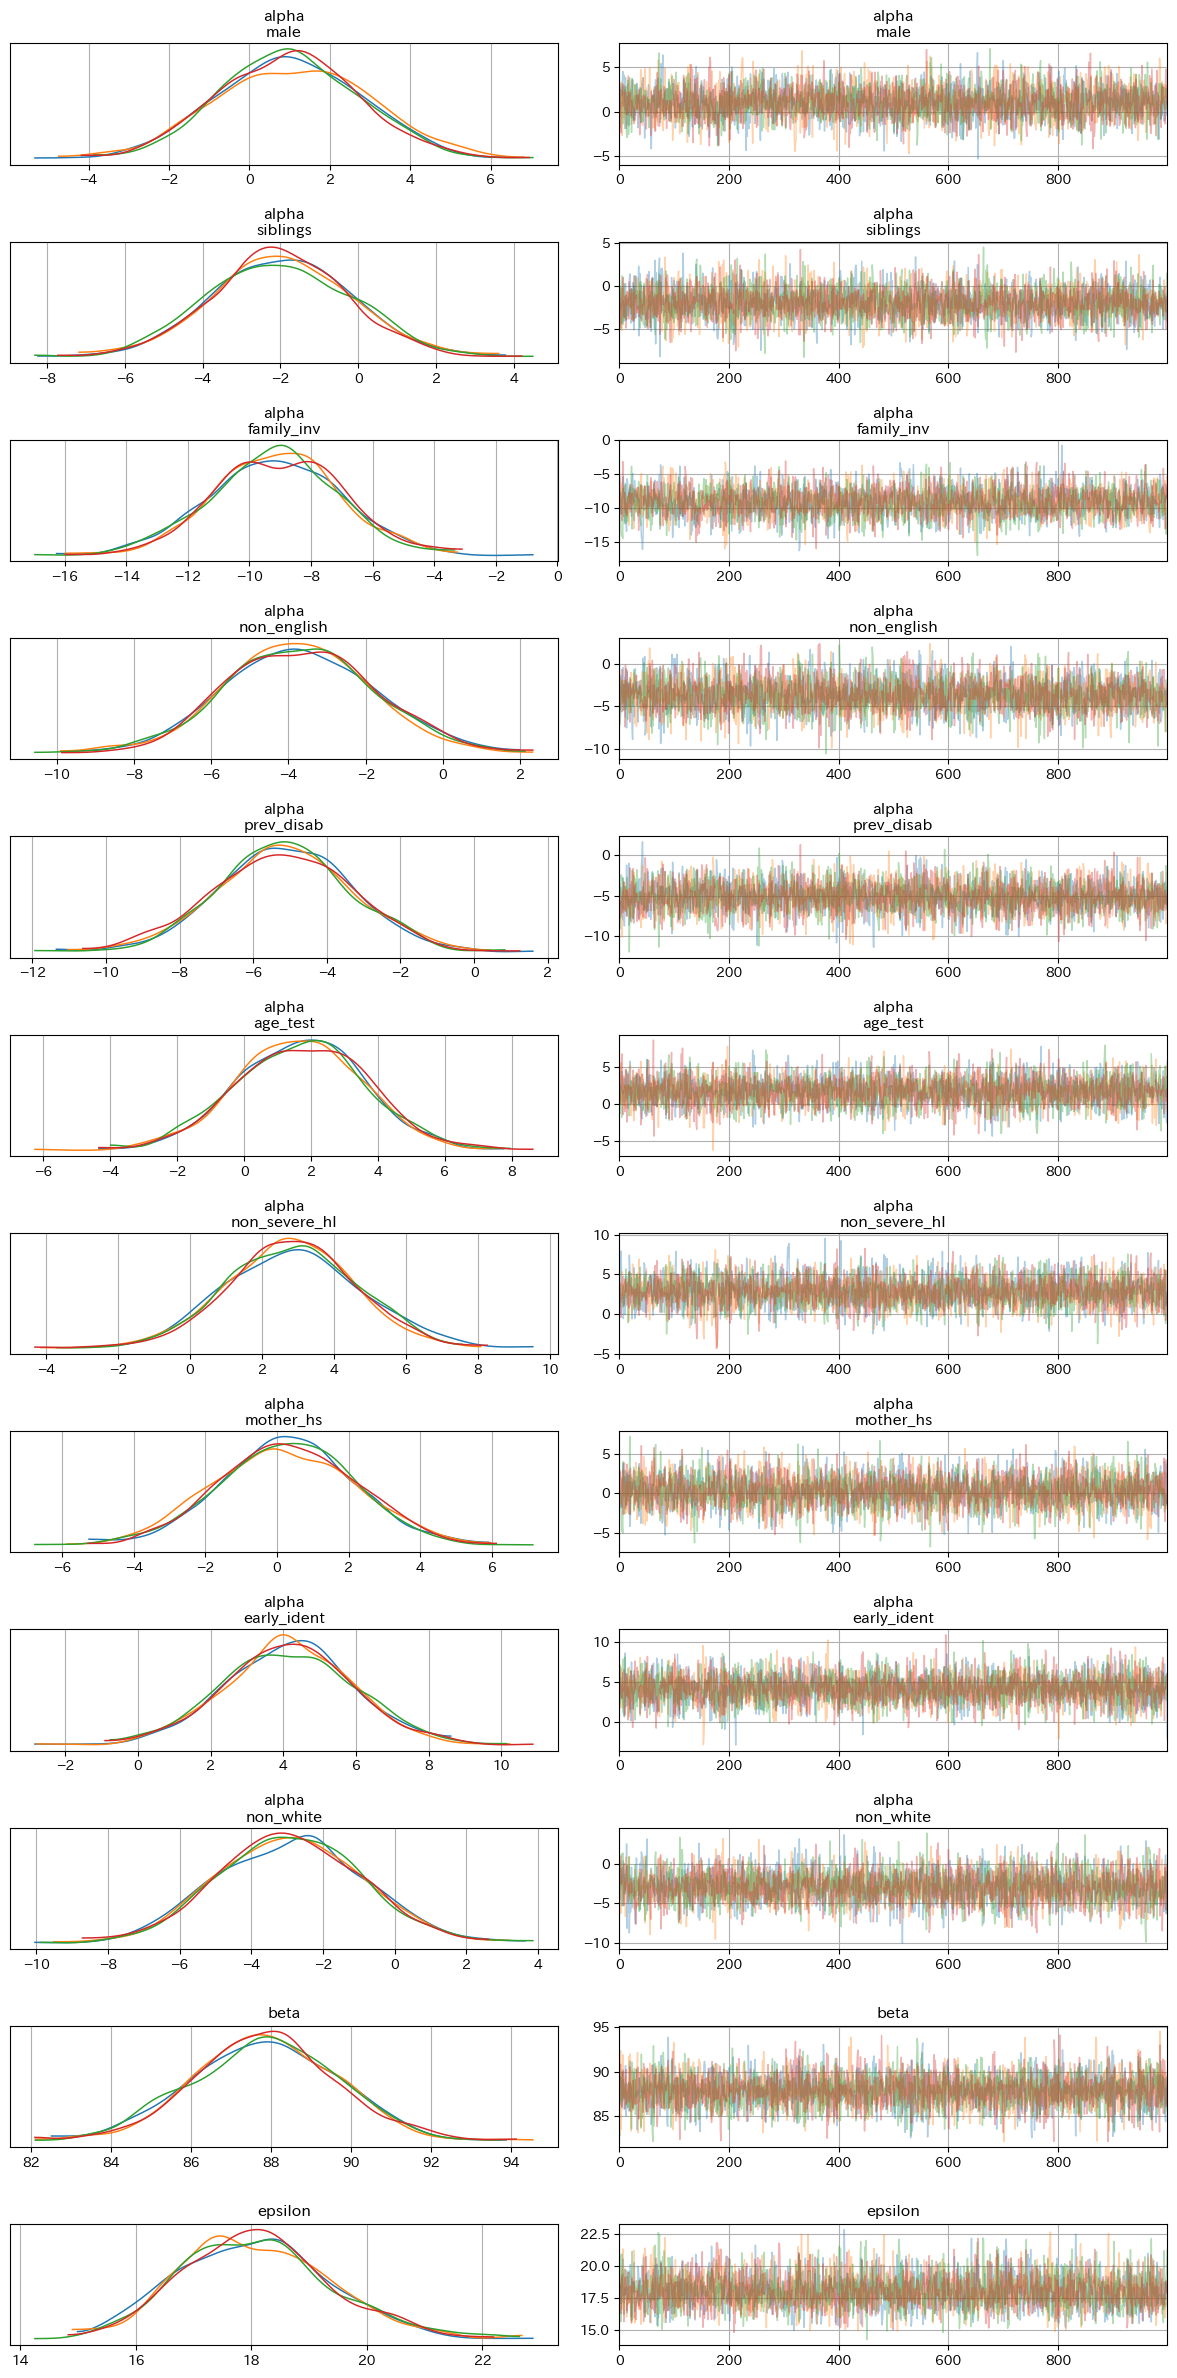

In [14]:
with model1:
    idata1 = pm.sample(random_seed=42, target_accept=0.95)

# plot_trace関数で推論結果の確認
az.plot_trace(idata1, var_names=['alpha', 'beta', 'epsilon'], compact=False)
plt.tight_layout();

#### サンプリング結果の統計情報取得

In [15]:
summary1 = az.summary(idata1, var_names=['alpha'])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],1.008,1.799,-2.223,4.446,0.029,0.025,3877.000,3089.000,1.000
alpha[siblings],-1.988,1.805,-5.316,1.462,0.026,0.021,4873.000,3306.000,1.000
alpha[family_inv],-9.117,2.081,-12.962,-5.078,0.037,0.026,3184.000,2829.000,1.000
alpha[non_english],-3.721,1.929,-7.205,0.024,0.029,0.021,4425.000,2845.000,1.000
alpha[prev_disab],-5.151,1.833,-8.543,-1.689,0.028,0.020,4172.000,2902.000,1.000
alpha[age_test],1.700,1.903,-2.105,5.043,0.028,0.023,4487.000,3291.000,1.000
alpha[non_severe_hl],2.832,1.816,-0.442,6.324,0.028,0.021,4198.000,2615.000,1.000
alpha[mother_hs],0.265,1.969,-3.311,4.131,0.033,0.028,3648.000,2972.000,1.000
alpha[early_ident],4.143,1.770,0.530,7.286,0.025,0.018,5134.000,3314.000,1.000
alpha[non_white],-2.929,1.996,-6.404,0.991,0.032,0.023,4006.000,2988.000,1.000


#### plot_forest関数で各項目の寄与度の確認

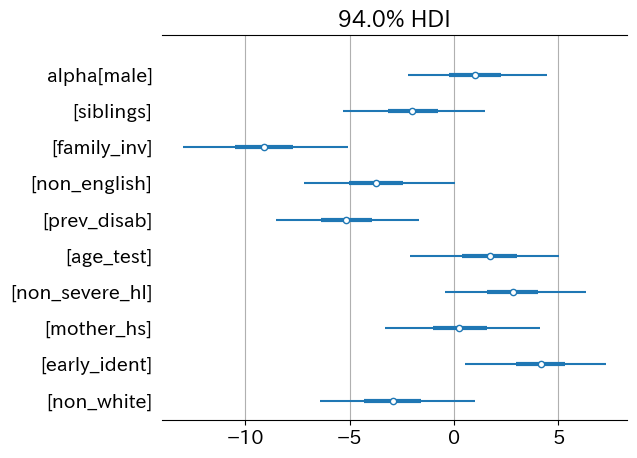

In [16]:
az.plot_forest(idata1, combined=True, var_names=['alpha']);

#### plot_forest関数　combinedオプションを指定しない場合

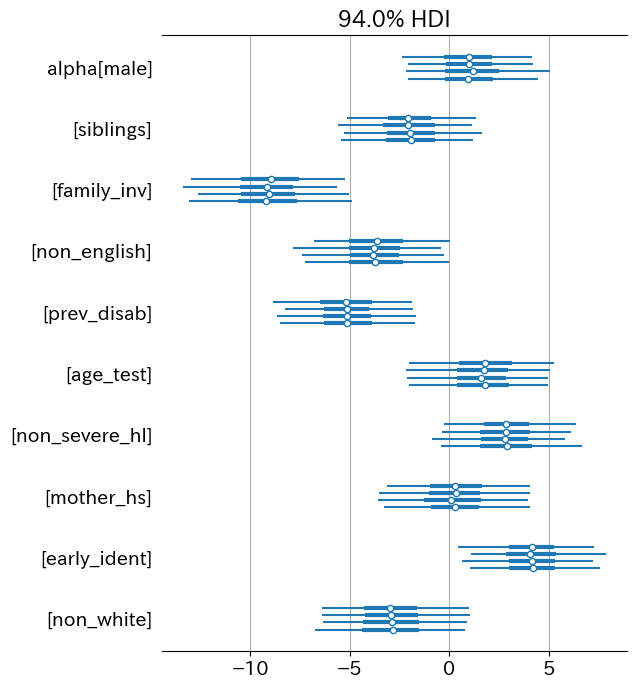

In [17]:
az.plot_forest(idata1, var_names=['alpha']);

### コラム　チュートリアルの確率モデル

#### 確率モデル定義

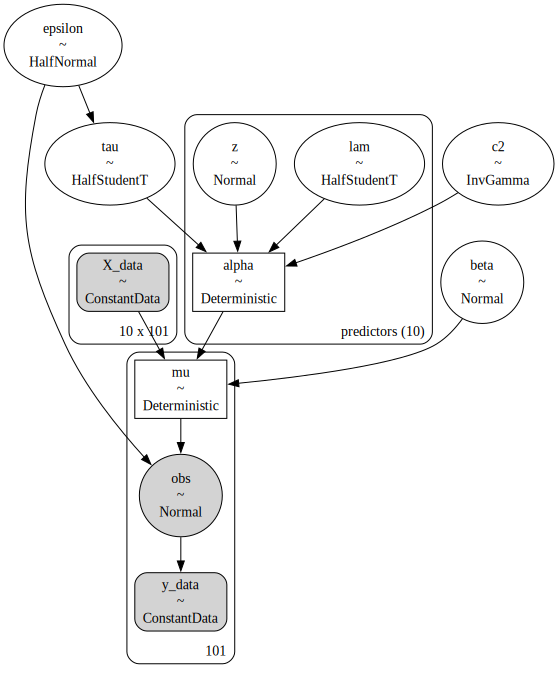

In [18]:
# D0の定義
D0 = int(D / 2)

# 説明変数リストをpredictorsとして定義
model2 = pm.Model(coords={'predictors': columns})

with model2:

    # Xは従来のベクトルが行列になる。転置していることに注意
    X_data = pm.ConstantData('X_data', X.T)

    # yが回帰モデルの目的変数
    y_data = pm.ConstantData('y_data', y)

    # 誤差の分布 sigma -> epsilon 文字の置き換えのみ
    epsilon = pm.HalfNormal('epsilon', sigma=25.0)

    # 一次関数の係数の分布　beta -> alpha 定義内容も全面的に変更

    # 事前分布の全体的な縮小
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * epsilon / np.sqrt(N))

    # 事前分布の局所的な縮小
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")

    alpha = pm.Deterministic(
        "alpha", z * tau * lam * pm.math.sqrt(
        c2 / (c2 + tau**2 * lam**2)), dims="predictors")

    # 定数項　beta0 -> beta　文字の置き換えのみ
    beta = pm.Normal("beta",  mu=100.0, sigma=25.0)

    # 正規分布の平均　mu np.dotを@に変えたがロジックは同じ
    mu = pm.Deterministic('mu', alpha @ X_data + beta)

    # 観測値の分布　scores -> obs 文字の置き換えのみ
    obs = pm.Normal("obs", mu, epsilon, observed=y_data)

# 確率モデル可視化
g = pm.model_to_graphviz(model2)
display(g)

#### サンプリングと推論結果の確認

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, tau, lam, c2, z, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


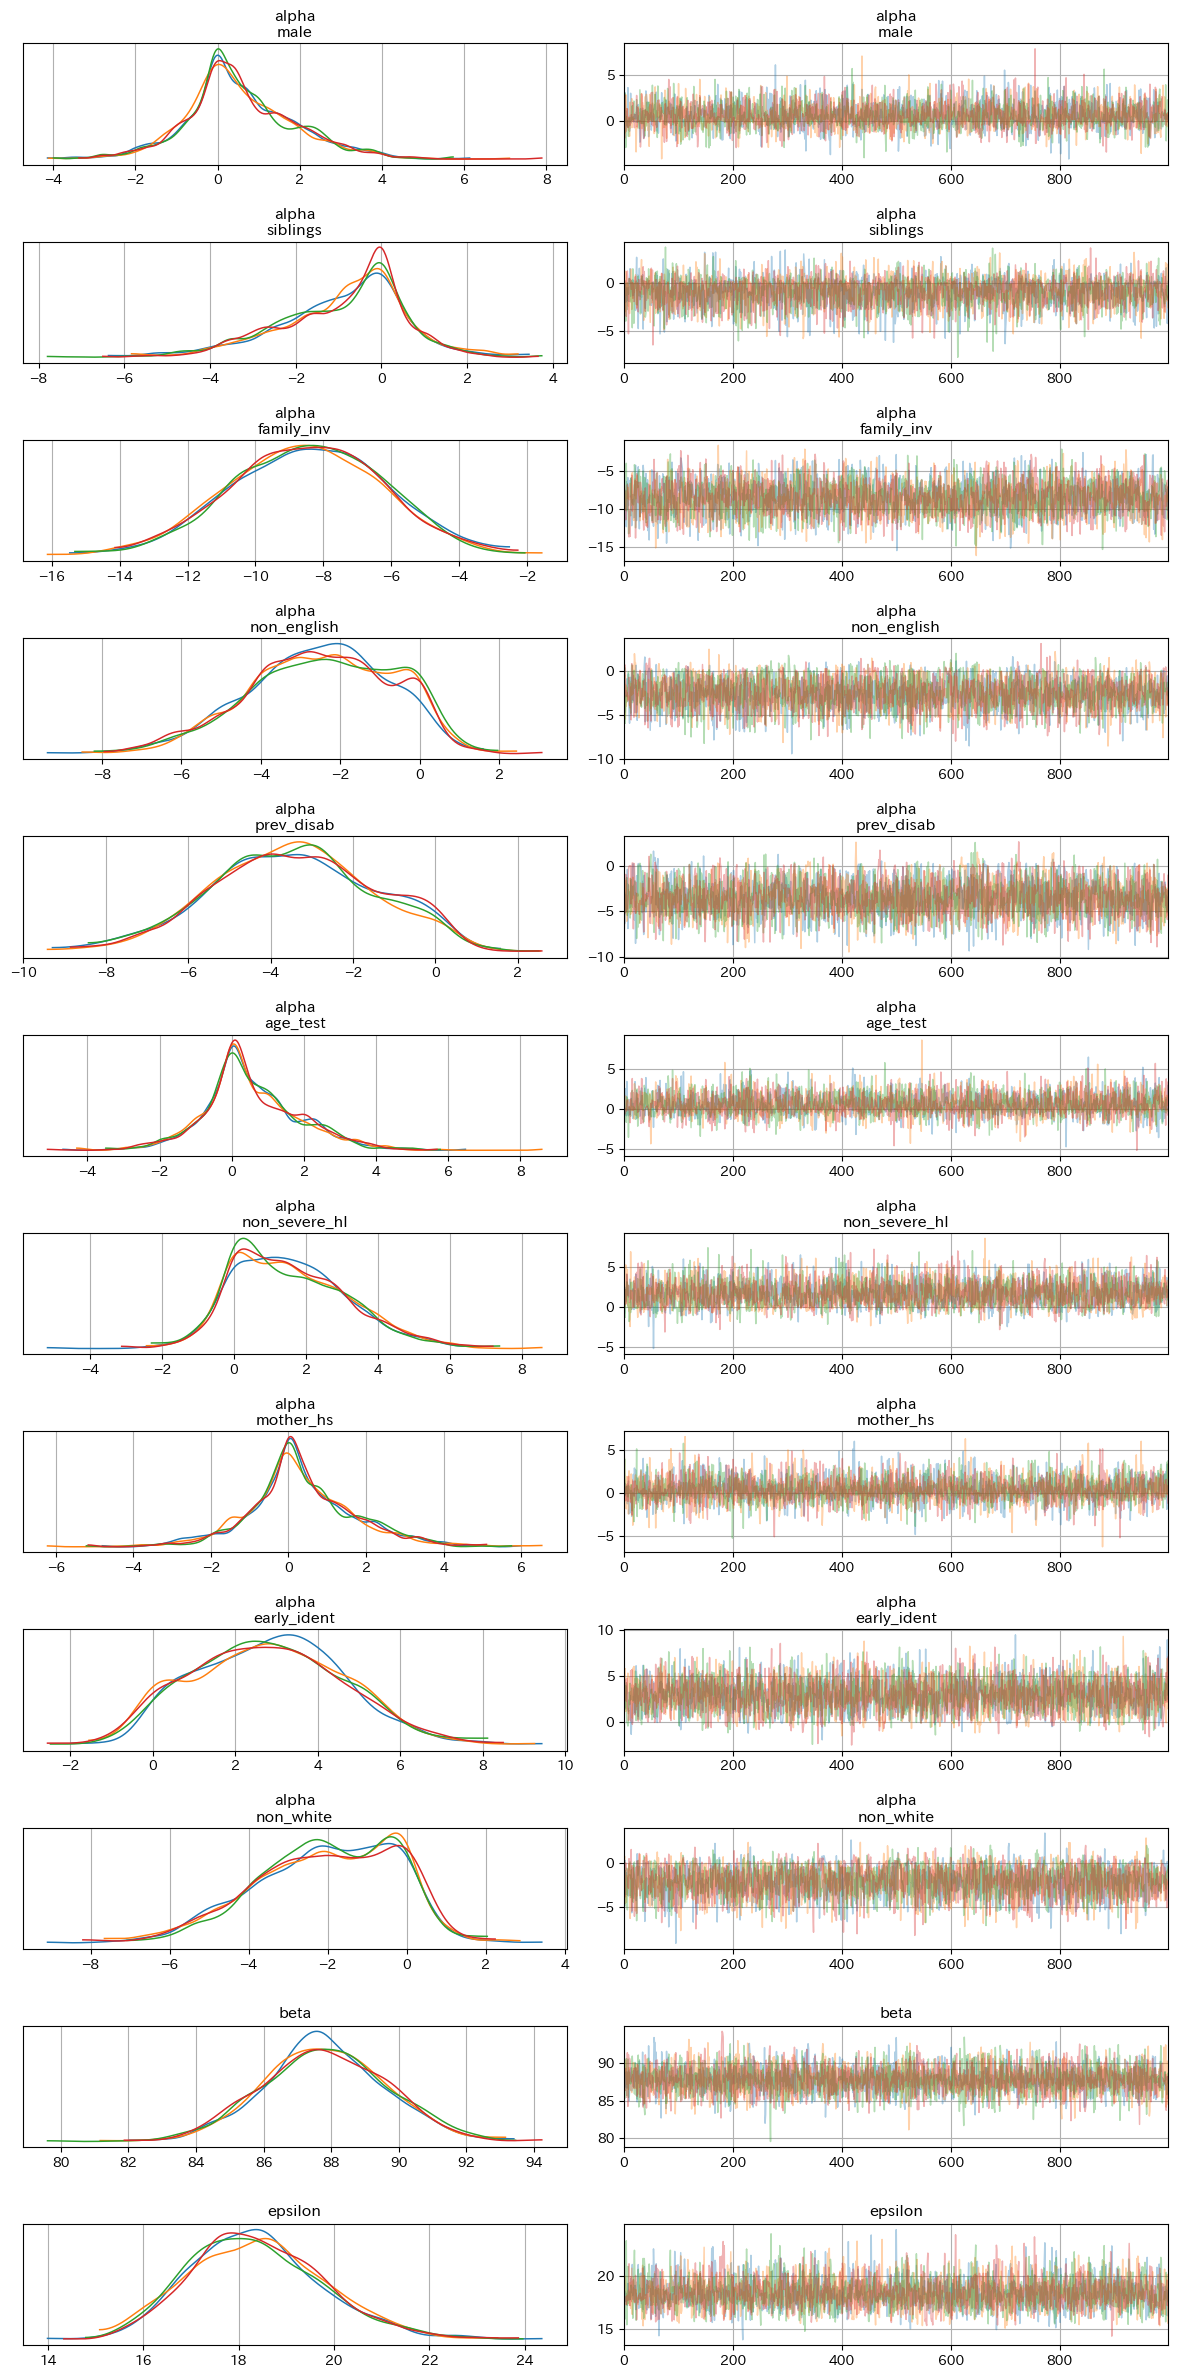

In [19]:
with model2:
    idata2 = pm.sample(random_seed=42, target_accept=0.95)

# plot_trace関数で推論結果の確認
az.plot_trace(idata2, var_names=['alpha', 'beta', 'epsilon'], compact=False)
plt.tight_layout();

#### plot_forest関数で各項目の寄与度の確認

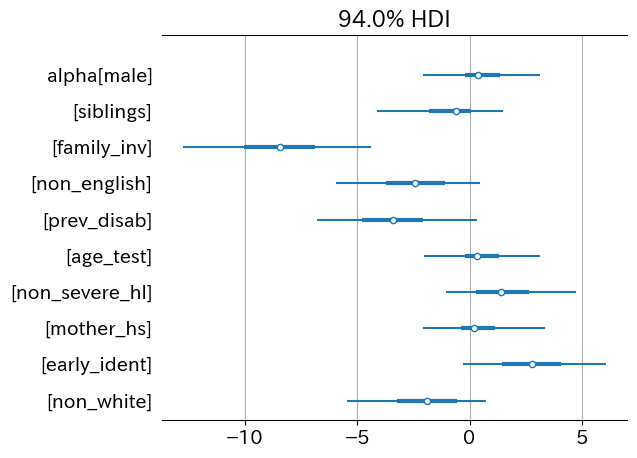

In [20]:
az.plot_forest(idata2, combined=True, var_names=['alpha']);

#### サンプリング結果の統計分析

In [21]:
summary2 = az.summary(idata2, var_names=['alpha'])
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],0.561,1.334,-2.058,3.148,0.019,0.015,4708.000,3513.000,1.000
alpha[siblings],-0.899,1.481,-4.093,1.474,0.022,0.016,4330.000,3869.000,1.000
alpha[family_inv],-8.471,2.233,-12.719,-4.396,0.040,0.028,3192.000,2918.000,1.000
alpha[non_english],-2.479,1.803,-5.939,0.443,0.031,0.022,3040.000,2723.000,1.000
alpha[prev_disab],-3.416,1.978,-6.770,0.342,0.035,0.025,3050.000,1403.000,1.000
alpha[age_test],0.548,1.339,-2.024,3.138,0.020,0.016,4334.000,3444.000,1.000
alpha[non_severe_hl],1.575,1.605,-1.050,4.710,0.027,0.019,3217.000,3325.000,1.000
alpha[mother_hs],0.353,1.388,-2.077,3.363,0.020,0.017,4928.000,3401.000,1.000
alpha[early_ident],2.801,1.816,-0.305,6.075,0.030,0.021,3398.000,1974.000,1.000
alpha[non_white],-2.014,1.773,-5.446,0.732,0.030,0.022,3049.000,2823.000,1.000


#### バージョンの確認

In [22]:
#!pip install watermark | tail -n 1
%load_ext watermark
%watermark --iversions

pymc               : 5.11.0
pandas             : 2.2.1
numpy              : 1.26.4
japanize_matplotlib: 1.1.3
arviz              : 0.17.1
seaborn            : 0.12.2
matplotlib         : 3.8.3

